In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_excel(io.BytesIO(uploaded["Dry_Bean_Dataset.xlsx"]))

# İlk 5 satırı göster
print(df.head())

Saving Dry_Bean_Dataset.xlsx to Dry_Bean_Dataset.xlsx
    Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  28395    610.291       208.178117       173.888747      1.197191   
1  28734    638.018       200.524796       182.734419      1.097356   
2  29380    624.110       212.826130       175.931143      1.209713   
3  30008    645.884       210.557999       182.516516      1.153638   
4  30140    620.134       201.847882       190.279279      1.060798   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0      0.549812       28715     190.141097  0.763923  0.988856   0.958027   
1      0.411785       29172     191.272750  0.783968  0.984986   0.887034   
2      0.562727       29690     193.410904  0.778113  0.989559   0.947849   
3      0.498616       30724     195.467062  0.782681  0.976696   0.903936   
4      0.333680       30417     195.896503  0.773098  0.990893   0.984877   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3

In [67]:
# %5 eksik veri eklenecek sütunlar
for col in ['Area', 'Perimeter']:
    df.loc[df.sample(frac=0.05, random_state=42).index, col] = np.nan

# %35 eksik veri eklenecek sütun
df.loc[df.sample(frac=0.35, random_state=42).index, 'Eccentricity'] = np.nan

# Eksik değerlerin sayısı
print(df.isnull().sum())

Area                681
Perimeter           681
MajorAxisLength       0
MinorAxisLength       0
AspectRation          0
Eccentricity       4764
ConvexArea            0
EquivDiameter         0
Extent                0
Solidity              0
roundness             0
Compactness           0
ShapeFactor1          0
ShapeFactor2          0
ShapeFactor3          0
ShapeFactor4          0
Class                 0
dtype: int64


In [68]:
# 'Area' ve 'Perimeter' sütunlarını ortalama ile dolduralım
df['Area'].fillna(df['Area'].mean(), inplace=True)
df['Perimeter'].fillna(df['Perimeter'].mean(), inplace=True)


#df.fillna({col: 'Area'}, inplace=True)
#df.fillna({col: 'Perimeter'}, inplace=True)


<ipython-input-68-8eb3ff45daa9>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Area'].fillna(df['Area'].mean(), inplace=True)
<ipython-input-68-8eb3ff45daa9>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [69]:
df.drop(columns=['Eccentricity'], inplace=True)

In [70]:
print(df.isnull().sum())
print(df.shape)           # Veri setinin son hali

Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Class              0
dtype: int64
(13611, 16)


In [71]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
z_scores = np.abs(zscore(df[numeric_columns]))
outliers = (z_scores > 3)
print("Aykırı değer sayısı (toplam hücre):", outliers.sum().sum())

Aykırı değer sayısı (toplam hücre): 3409


In [72]:
# Tüm aykırı değer içeren satırları silelim
df_clean = df[(z_scores < 3).all(axis=1)]

print("Yeni veri seti boyutu:", df_clean.shape)

Yeni veri seti boyutu: (12601, 16)


In [73]:
features = df_clean.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
df_scaled = df_clean.copy()
df_scaled[features] = scaler.fit_transform(df_clean[features])
print(df_scaled.head())

       Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0 -1.219771  -1.379233        -1.494873        -0.727947     -1.545888   
2 -1.159047  -1.289524        -1.424534        -0.658533     -1.494216   
3 -1.120332  -1.148174        -1.458858        -0.434717     -1.725621   
5 -1.103625  -1.219304        -1.428553        -0.468919     -1.653697   
6 -1.091419  -0.991406        -1.451410        -0.382970     -1.753971   

   ConvexArea  EquivDiameter    Extent  Solidity  roundness  Compactness  \
0   -1.175004      -1.302189  0.277321  0.348921   1.419271     1.808079   
2   -1.117223      -1.222499  0.584547  0.546120   1.239599     1.733102   
3   -1.055946      -1.172387  0.683443 -3.063248   0.464374     2.052976   
5   -1.063294      -1.150925  0.532051  0.532379   1.169025     1.977682   
6   -1.041367      -1.135304  0.244391 -0.990840  -0.433427     2.135498   

   ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  
0      0.666365      2.396131  

In [74]:
label_encoder = LabelEncoder()
df_scaled['Class'] = label_encoder.fit_transform(df_scaled['Class'])
print("Sınıf etiketleri:", list(label_encoder.classes_))
print(df_scaled['Class'].value_counts())

Sınıf etiketleri: ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']
Class
3    3520
6    2623
5    2011
4    1632
2    1544
0    1262
1       9
Name: count, dtype: int64


In [75]:
X = df_scaled.drop(columns=['Class'])
y = df_scaled['Class']
pca = PCA()
X_pca = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_
print("Açıklanan varyans oranları:", explained_variance)

Açıklanan varyans oranları: [6.05636914e-01 2.16915824e-01 7.07359442e-02 5.65899623e-02
 3.19311256e-02 6.72900955e-03 6.27986386e-03 2.77800305e-03
 1.99008620e-03 3.19105991e-04 7.66263590e-05 1.12884571e-05
 5.43437009e-06 6.74744427e-07 1.36741178e-07]


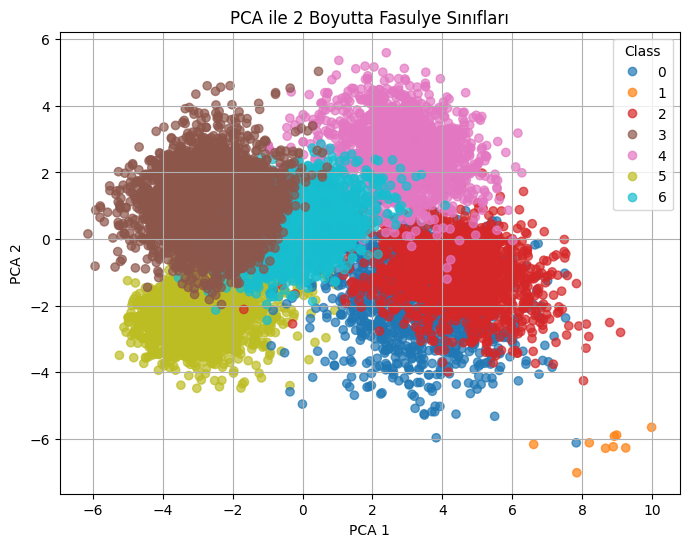

In [76]:
# İlk 2 bileşeni al
pca2 = PCA(n_components=2)
X_pca_2d = pca2.fit_transform(X)

# 2D Görselleştirme
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA ile 2 Boyutta Fasulye Sınıfları")
plt.legend(*scatter.legend_elements(), title="Class")
plt.grid(True)
plt.show()

In [77]:
# LDA nesnesi oluştur (3 bileşen istiyoruz)
lda = LDA(n_components=3)
X_lda = lda.fit_transform(X, y)
print("LDA ile elde edilen bileşenlerin şekli:", X_lda.shape)

LDA ile elde edilen bileşenlerin şekli: (12601, 3)


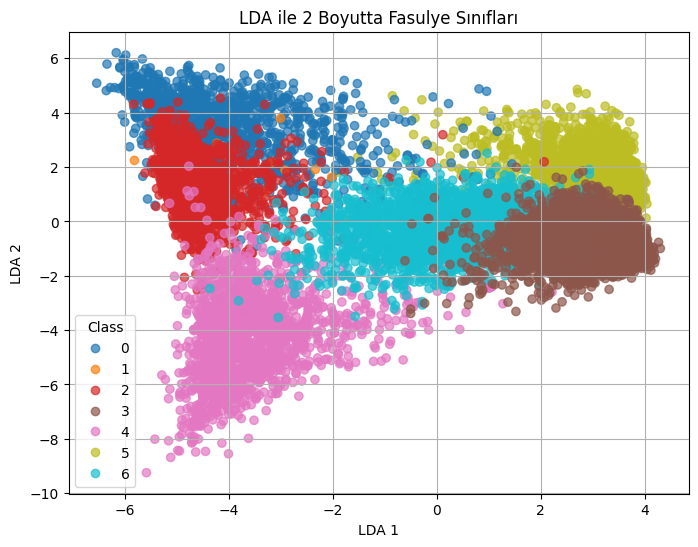

In [78]:
# 2 boyutlu grafik (ilk 2 bileşen)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.xlabel("LDA 1")
plt.ylabel("LDA 2")
plt.title("LDA ile 2 Boyutta Fasulye Sınıfları")
plt.legend(*scatter.legend_elements(), title="Class")
plt.grid(True)
plt.show()

In [79]:
def evaluate_model(model, param_grid, X, y):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], []

    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)
        clf.fit(X_train, y_train)
        best_model = clf.best_estimator_

        y_pred = best_model.predict(X_test)
        acc_scores.append(accuracy_score(y_test, y_pred))
        prec_scores.append(precision_score(y_test, y_pred, average='macro'))
        rec_scores.append(recall_score(y_test, y_pred, average='macro'))
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))

    return {
        'accuracy': (np.mean(acc_scores), np.std(acc_scores)),
        'precision': (np.mean(prec_scores), np.std(prec_scores)),
        'recall': (np.mean(rec_scores), np.std(rec_scores)),
        'f1': (np.mean(f1_scores), np.std(f1_scores))
    }

In [80]:
# Ham veri (ölçeklenmiş ve ayıklanmış haliyle)
X_raw = df_scaled.drop(columns=['Class']).values
y_raw = df_scaled['Class'].values

# Parametre aralığı (grid search için)
logreg_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear']
}


logreg_results = evaluate_model(LogisticRegression(max_iter=1000), logreg_params, X_raw, y_raw)
for metric, (mean, std) in logreg_results.items():
    print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")

Accuracy: 0.9182 ± 0.0046
Precision: 0.9369 ± 0.0035
Recall: 0.9331 ± 0.0034
F1: 0.9347 ± 0.0033


In [81]:
pca_final = PCA(n_components=0.95)
X_pca = pca_final.fit_transform(X_raw)
print("PCA veri şekli:", X_pca.shape)

PCA veri şekli: (12601, 5)


In [82]:
logreg_results_pca = evaluate_model(LogisticRegression(max_iter=1000), logreg_params, X_pca, y_raw)

print("\n📊 PCA Temsili ile Logistic Regression:")
for metric, (mean, std) in logreg_results_pca.items():
    print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


📊 PCA Temsili ile Logistic Regression:
Accuracy: 0.9028 ± 0.0032
Precision: 0.7800 ± 0.0023
Recall: 0.7755 ± 0.0031
F1: 0.7775 ± 0.0023


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [83]:
lda_final = LDA(n_components=3)
X_lda = lda_final.fit_transform(X_raw, y_raw)

print("LDA veri şekli:", X_lda.shape)


LDA veri şekli: (12601, 3)


In [84]:
logreg_results_lda = evaluate_model(LogisticRegression(max_iter=1000), logreg_params, X_lda, y_raw)

print("\n📊 LDA Temsili ile Logistic Regression:")
for metric, (mean, std) in logreg_results_lda.items():
    print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


📊 LDA Temsili ile Logistic Regression:
Accuracy: 0.8870 ± 0.0049
Precision: 0.7628 ± 0.0042
Recall: 0.7535 ± 0.0053
F1: 0.7571 ± 0.0046


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [85]:
tree_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

In [86]:
tree_results_raw = evaluate_model(DecisionTreeClassifier(random_state=42), tree_params, X_raw, y_raw)

print("\n🌿 Decision Tree – Ham Veri:")
for metric, (mean, std) in tree_results_raw.items():
    print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🌿 Decision Tree – Ham Veri:
Accuracy: 0.9018 ± 0.0024
Precision: 0.8697 ± 0.0548
Recall: 0.8625 ± 0.0547
F1: 0.8626 ± 0.0499


In [87]:
tree_results_pca = evaluate_model(DecisionTreeClassifier(random_state=42), tree_params, X_pca, y_raw)

print("\n🌿 Decision Tree – PCA:")
for metric, (mean, std) in tree_results_pca.items():
    print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🌿 Decision Tree – PCA:
Accuracy: 0.8918 ± 0.0030
Precision: 0.8128 ± 0.0566
Recall: 0.8087 ± 0.0584
F1: 0.8100 ± 0.0580


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [88]:
tree_results_lda = evaluate_model(DecisionTreeClassifier(random_state=42), tree_params, X_lda, y_raw)

print("\n🌿 Decision Tree – LDA:")
for metric, (mean, std) in tree_results_lda.items():
    print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


🌿 Decision Tree – LDA:
Accuracy: 0.8794 ± 0.0039
Precision: 0.7522 ± 0.0053
Recall: 0.7499 ± 0.0034
F1: 0.7501 ± 0.0041


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [89]:
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

In [90]:
rf_results_raw = evaluate_model(RandomForestClassifier(random_state=42), rf_params, X_raw, y_raw)

print("\n🌲 Random Forest – Ham Veri:")
for metric, (mean, std) in rf_results_raw.items():
    print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")


🌲 Random Forest – Ham Veri:
Accuracy: 0.9206 ± 0.0072
Precision: 0.9378 ± 0.0050
Recall: 0.9187 ± 0.0332
F1: 0.9256 ± 0.0235


In [91]:
rf_results_pca = evaluate_model(RandomForestClassifier(random_state=42), rf_params, X_pca, y_raw)

print("\n🌲 Random Forest – PCA:")
for metric, (mean, std) in rf_results_pca.items():
    print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")


🌲 Random Forest – PCA:
Accuracy: 0.9191 ± 0.0039
Precision: 0.9367 ± 0.0028
Recall: 0.9332 ± 0.0028
F1: 0.9347 ± 0.0027


In [92]:
rf_results_lda = evaluate_model(RandomForestClassifier(random_state=42), rf_params, X_lda, y_raw)

print("\n🌲 Random Forest – LDA:")
for metric, (mean, std) in rf_results_lda.items():
    print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🌲 Random Forest – LDA:
Accuracy: 0.8998 ± 0.0054
Precision: 0.8713 ± 0.0594
Recall: 0.8520 ± 0.0558
F1: 0.8590 ± 0.0554


In [93]:
xgb_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.01]
}

In [94]:
xgb_results_raw = evaluate_model(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                                 xgb_params, X_raw, y_raw)

print("\n⚡ XGBoost – Ham Veri:")
for metric, (mean, std) in xgb_results_raw.items():
    print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:39:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:39:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost


⚡ XGBoost – Ham Veri:
Accuracy: 0.9257 ± 0.0062
Precision: 0.9143 ± 0.0590
Recall: 0.8824 ± 0.0565
F1: 0.8935 ± 0.0549


In [95]:
xgb_results_pca = evaluate_model(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                                 xgb_params, X_pca, y_raw)

print("\n⚡ XGBoost – PCA:")
for metric, (mean, std) in xgb_results_pca.items():
    print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


⚡ XGBoost – PCA:
Accuracy: 0.9187 ± 0.0048
Precision: 0.9268 ± 0.0171
Recall: 0.9177 ± 0.0315
F1: 0.9188 ± 0.0214


In [96]:
xgb_results_lda = evaluate_model(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                                 xgb_params, X_lda, y_raw)

print("\n⚡ XGBoost – LDA:")
for metric, (mean, std) in xgb_results_lda.items():
    print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn


⚡ XGBoost – LDA:
Accuracy: 0.8986 ± 0.0038
Precision: 0.8269 ± 0.0588
Recall: 0.8224 ± 0.0561
F1: 0.8206 ± 0.0506


In [97]:
nb_results_raw = evaluate_model(GaussianNB(), {}, X_raw, y_raw)

print("\n📦 Naive Bayes – Ham Veri:")
for metric, (mean, std) in nb_results_raw.items():
    print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")


📦 Naive Bayes – Ham Veri:
Accuracy: 0.8953 ± 0.0052
Precision: 0.9016 ± 0.0189
Recall: 0.8963 ± 0.0290
F1: 0.8951 ± 0.0198


In [98]:
nb_results_pca = evaluate_model(GaussianNB(), {}, X_pca, y_raw)

print("\n📦 Naive Bayes – PCA:")
for metric, (mean, std) in nb_results_pca.items():
    print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")


📦 Naive Bayes – PCA:
Accuracy: 0.9004 ± 0.0044
Precision: 0.9099 ± 0.0179
Recall: 0.9204 ± 0.0047
F1: 0.9138 ± 0.0104


In [99]:
nb_results_lda = evaluate_model(GaussianNB(), {}, X_lda, y_raw)

print("\n📦 Naive Bayes – LDA:")
for metric, (mean, std) in nb_results_lda.items():
    print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")


📦 Naive Bayes – LDA:
Accuracy: 0.8931 ± 0.0027
Precision: 0.8845 ± 0.0265
Recall: 0.9026 ± 0.0041
F1: 0.8892 ± 0.0165


In [100]:
results_summary = {
    ('LogReg', 'Raw'): logreg_results,
    ('LogReg', 'PCA'): logreg_results_pca,
    ('LogReg', 'LDA'): logreg_results_lda,

    ('Tree', 'Raw'): tree_results_raw,
    ('Tree', 'PCA'): tree_results_pca,
    ('Tree', 'LDA'): tree_results_lda,

    ('RF', 'Raw'): rf_results_raw,
    ('RF', 'PCA'): rf_results_pca,
    ('RF', 'LDA'): rf_results_lda,

    ('XGB', 'Raw'): xgb_results_raw,
    ('XGB', 'PCA'): xgb_results_pca,
    ('XGB', 'LDA'): xgb_results_lda,

    ('NB', 'Raw'): nb_results_raw,
    ('NB', 'PCA'): nb_results_pca,
    ('NB', 'LDA'): nb_results_lda
}

rows = []
for (model, version), metrics in results_summary.items():
    row = {
        'Model': model,
        'Veri Temsili': version,
        'Accuracy': f"{metrics['accuracy'][0]:.4f} ± {metrics['accuracy'][1]:.4f}",
        'Precision': f"{metrics['precision'][0]:.4f} ± {metrics['precision'][1]:.4f}",
        'Recall': f"{metrics['recall'][0]:.4f} ± {metrics['recall'][1]:.4f}",
        'F1 Score': f"{metrics['f1'][0]:.4f} ± {metrics['f1'][1]:.4f}",
    }
    rows.append(row)

df_results = pd.DataFrame(rows)
print(df_results)

     Model Veri Temsili         Accuracy        Precision           Recall  \
0   LogReg          Raw  0.9182 ± 0.0046  0.9369 ± 0.0035  0.9331 ± 0.0034   
1   LogReg          PCA  0.9028 ± 0.0032  0.7800 ± 0.0023  0.7755 ± 0.0031   
2   LogReg          LDA  0.8870 ± 0.0049  0.7628 ± 0.0042  0.7535 ± 0.0053   
3     Tree          Raw  0.9018 ± 0.0024  0.8697 ± 0.0548  0.8625 ± 0.0547   
4     Tree          PCA  0.8918 ± 0.0030  0.8128 ± 0.0566  0.8087 ± 0.0584   
5     Tree          LDA  0.8794 ± 0.0039  0.7522 ± 0.0053  0.7499 ± 0.0034   
6       RF          Raw  0.9206 ± 0.0072  0.9378 ± 0.0050  0.9187 ± 0.0332   
7       RF          PCA  0.9191 ± 0.0039  0.9367 ± 0.0028  0.9332 ± 0.0028   
8       RF          LDA  0.8998 ± 0.0054  0.8713 ± 0.0594  0.8520 ± 0.0558   
9      XGB          Raw  0.9257 ± 0.0062  0.9143 ± 0.0590  0.8824 ± 0.0565   
10     XGB          PCA  0.9187 ± 0.0048  0.9268 ± 0.0171  0.9177 ± 0.0315   
11     XGB          LDA  0.8986 ± 0.0038  0.8269 ± 0.0588  0.822

In [101]:
class_names = label_encoder.classes_.tolist()

In [102]:
def full_roc_auc_summary(models_dict, data_dict, y, class_names):
    all_results = []

    for model_name, model in models_dict.items():
        for rep_name, X in data_dict.items():

            y_bin = label_binarize(y, classes=np.unique(y))
            n_classes = y_bin.shape[1]

            model.fit(X, y)
            y_score = model.predict_proba(X)

            plt.figure(figsize=(8,6))
            plt.title(f"{model_name} – {rep_name}")
            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
                roc_auc = auc(fpr, tpr)
                all_results.append({
                    'Model': model_name,
                    'Veri Temsili': rep_name,
                    'Sınıf': class_names[i],
                    'ROC-AUC': roc_auc
                })
                plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

            plt.plot([0,1], [0,1], 'k--', lw=1)
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc='lower right')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    return pd.DataFrame(all_results)


In [103]:
models_dict = {
    "Logistic Regression": LogisticRegression(C=1, solver='liblinear', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=2, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "Naive Bayes": GaussianNB()
}

data_dict = {
    "Ham Veri": X_raw,
    "PCA": X_pca,
    "LDA": X_lda
}


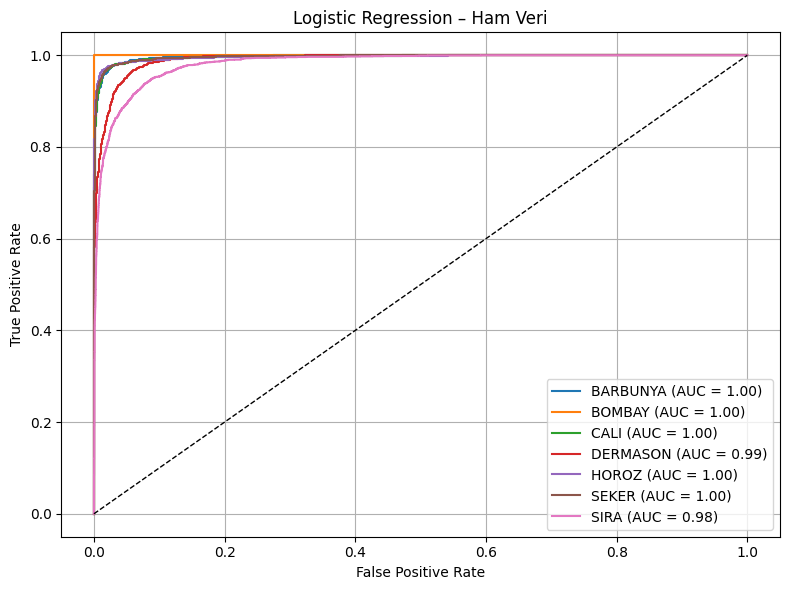

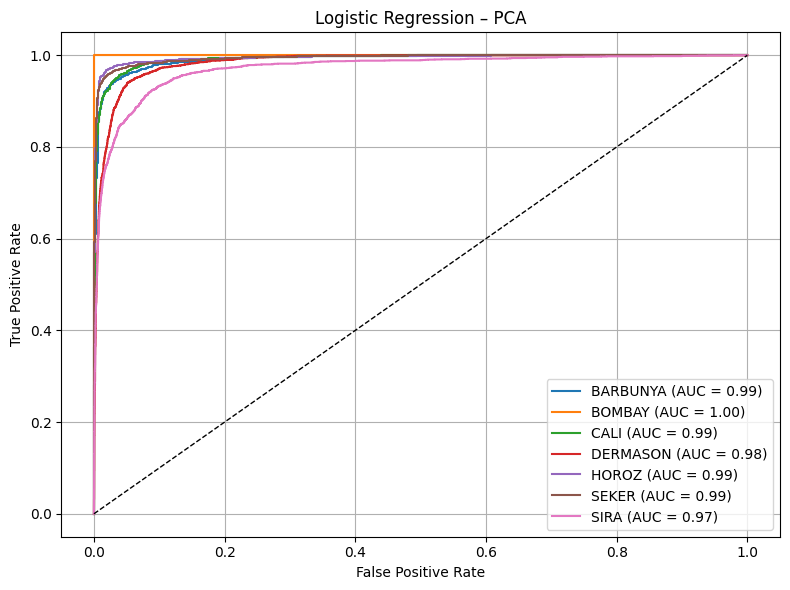

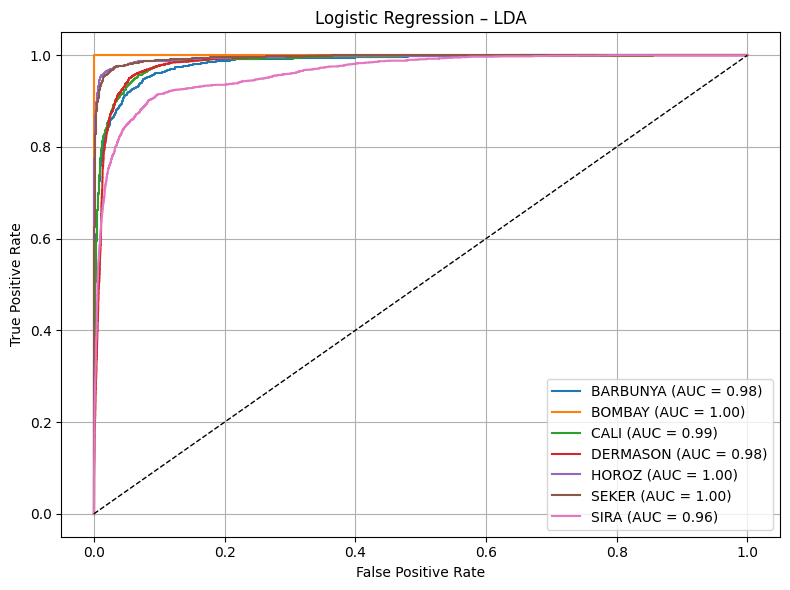

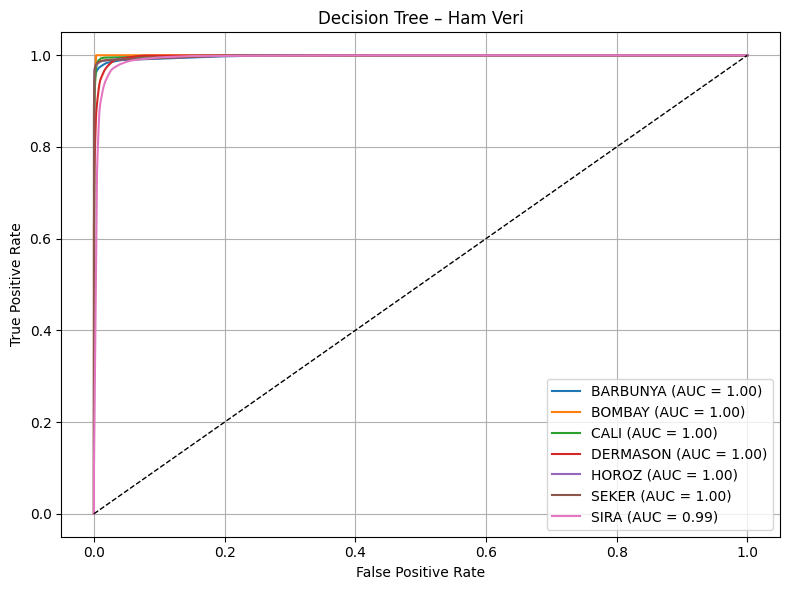

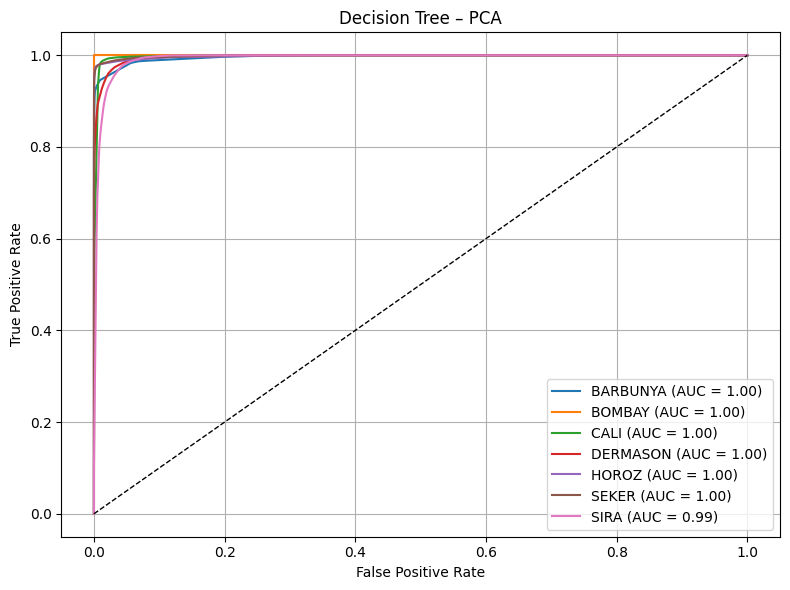

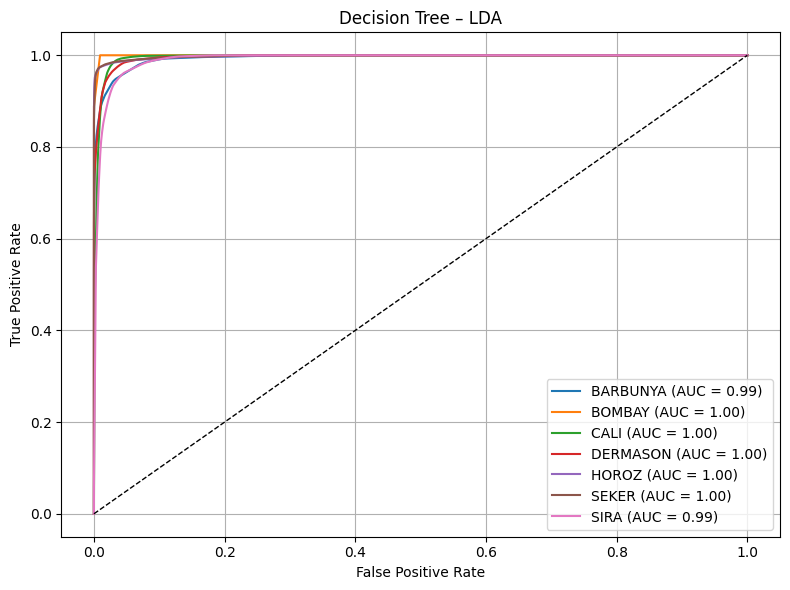

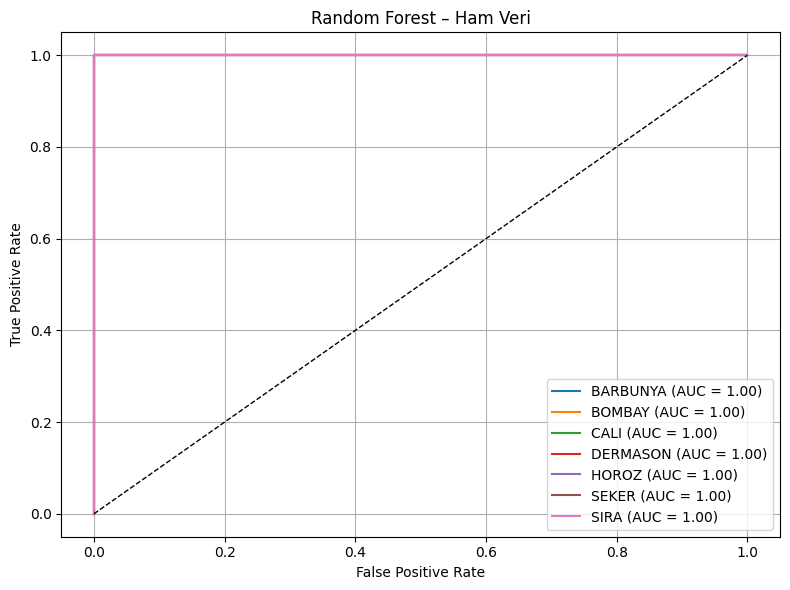

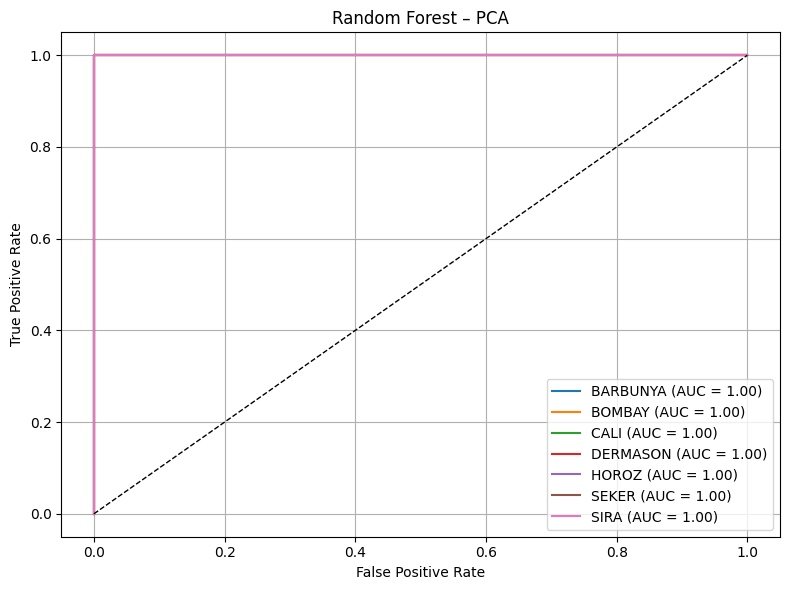

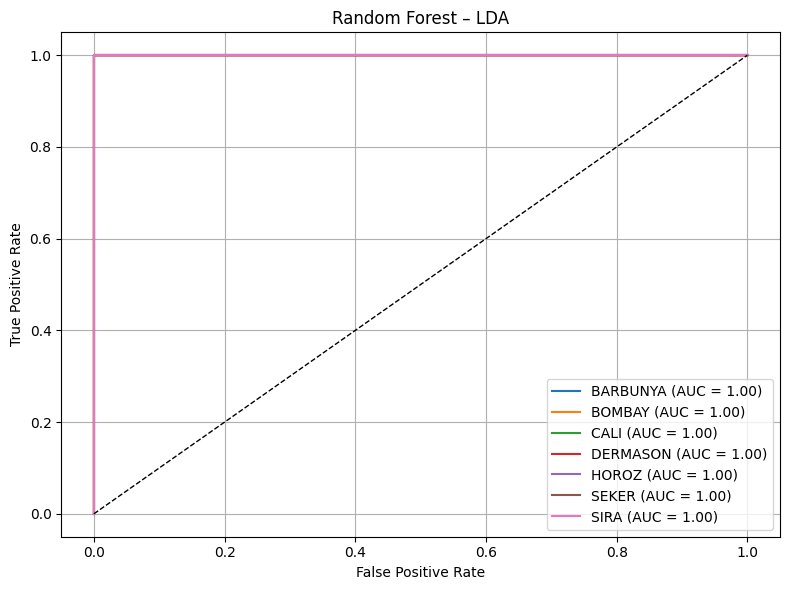

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:41:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


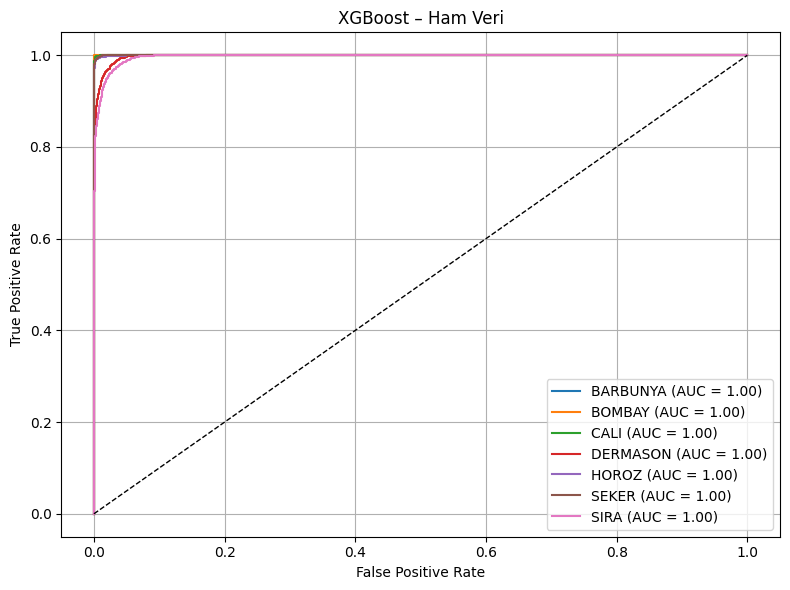

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:41:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


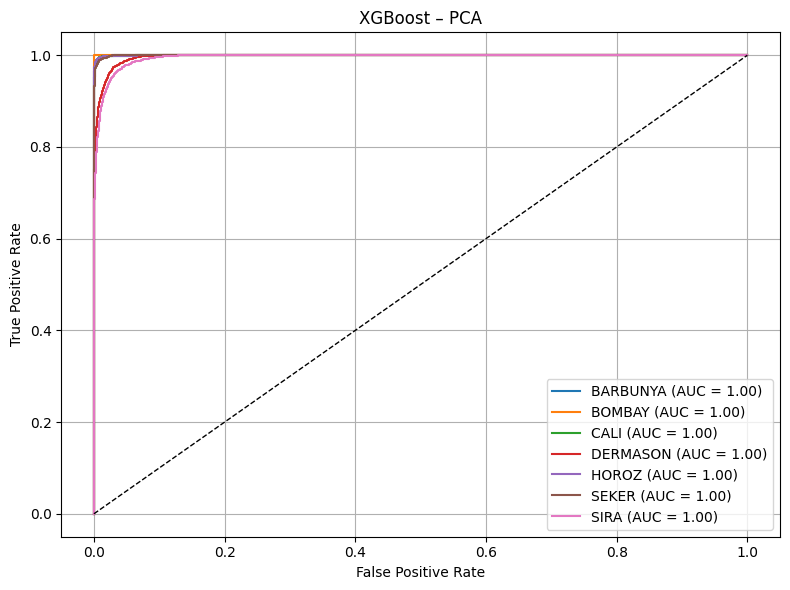

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:41:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


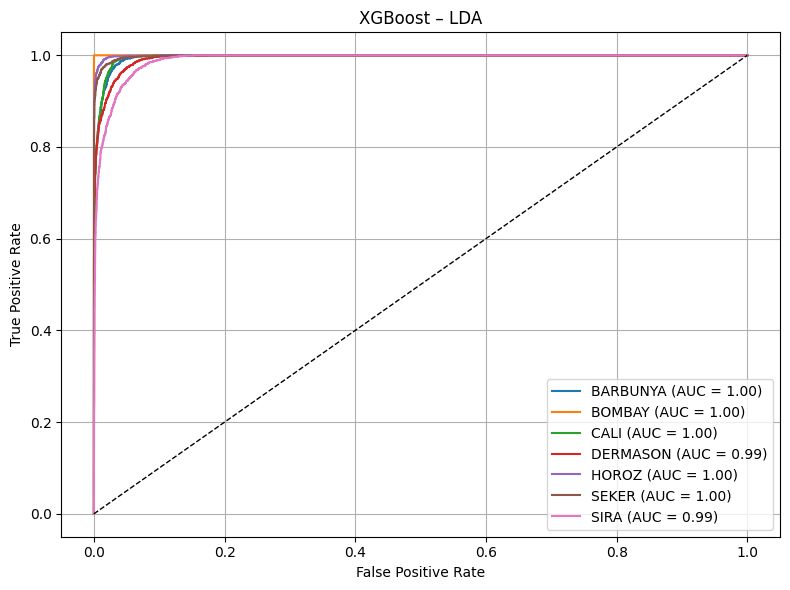

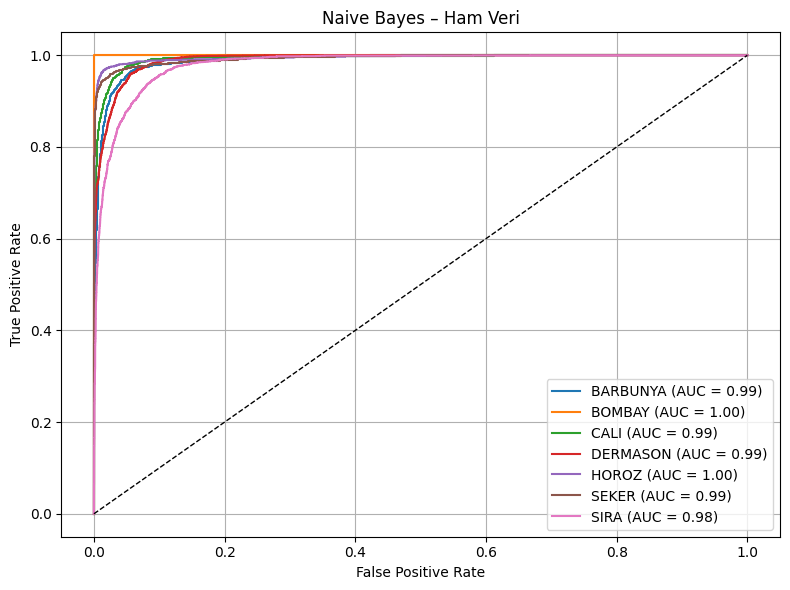

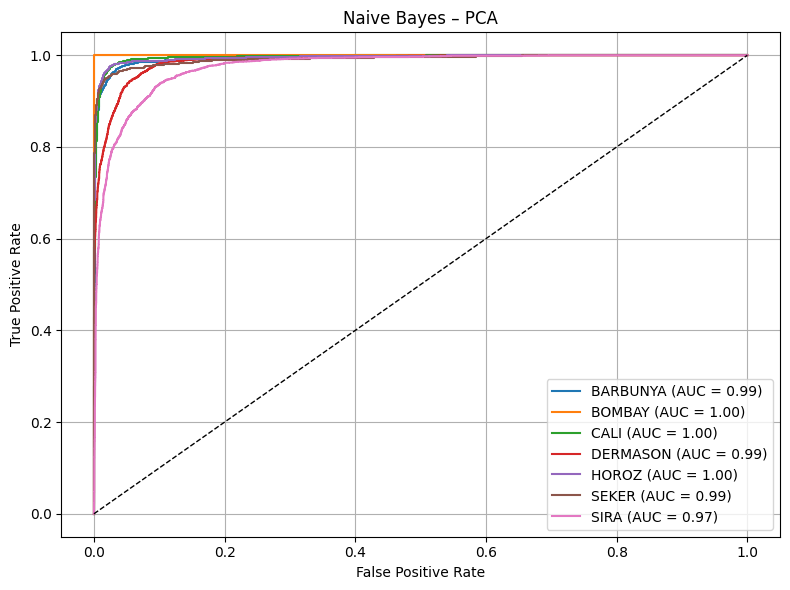

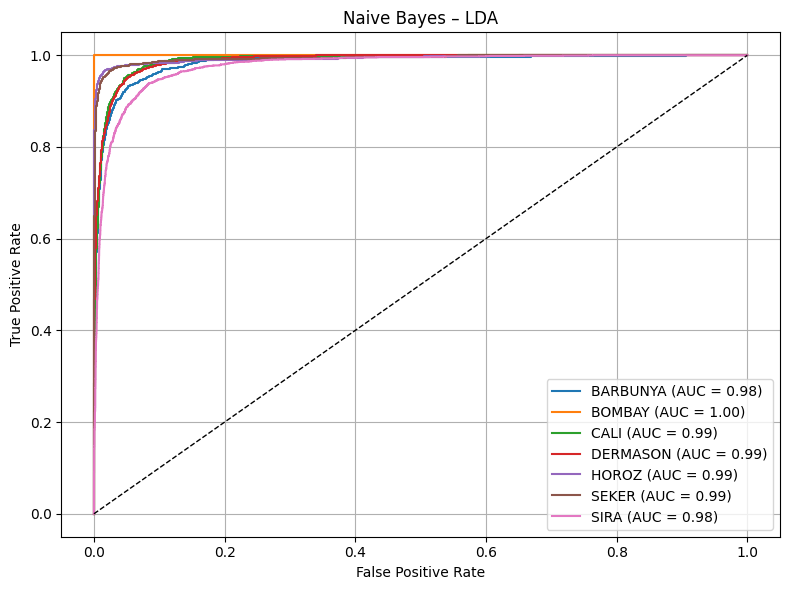

Veri Temsili         Ham Veri     LDA     PCA
Model                                        
Decision Tree          0.9979  0.9960  0.9972
Logistic Regression    0.9941  0.9866  0.9895
Naive Bayes            0.9916  0.9892  0.9912
Random Forest          1.0000  1.0000  1.0000
XGBoost                0.9992  0.9965  0.9987


In [104]:
auc_all_df = full_roc_auc_summary(models_dict, data_dict, y_raw, class_names)

summary_auc = auc_all_df.groupby(['Model', 'Veri Temsili'])['ROC-AUC'].mean().round(4).reset_index()
print(summary_auc.pivot(index='Model', columns='Veri Temsili', values='ROC-AUC'))
